In [1]:
import pickle
import pandas as pd

# Load the large dataset
with open("data/all_points_may_2024.pkl", "rb") as file:
    all_points = pickle.load(file)

# Explore the structure
print(f"Top-level type: {type(all_points)}")
print(f"Number of patient entries: {len(all_points)}")

Top-level type: <class 'dict'>
Number of patient entries: 190


Hence, the dataset contains data for 190 patients.
For each patient:
* Metadata: Sex, HTA, Age, PVC_transition, SOO_chamber, Height, Weight, BMI, DM, DLP, Smoker, COPD, Sleep_apnea, CLINICAL_SCORE, SOO, OTorigin.
* Structures

In [2]:
# Initial inspection of metadata only (one row per patient)
overview_metadata = []
for patient_id, patient_data in all_points.items():
    overview_metadata.append({
        "PatientID": patient_id,
        "Sex": patient_data.get("Sex", [None])[0],
        "Age": patient_data.get("Age", [None])[0],
        "PVC_transition": patient_data.get("PVC_transition", [None])[0],
        "SOO_chamber": patient_data.get("SOO_chamber", [None])[0],
        "Height": patient_data.get("Height", [None])[0],
        "Weight": patient_data.get("Weight", [None])[0],
        "BMI": patient_data.get("BMI", [None])[0],
        "DM": patient_data.get("DM", [None])[0],
        "DLP": patient_data.get("DLP", [None])[0],
        "Smoker": patient_data.get("Smoker", [None])[0],
        "COPD": patient_data.get("COPD", [None])[0],
        "Sleep_apnea": patient_data.get("Sleep_apnea", [None])[0],
        "CLINICAL_SCORE": patient_data.get("CLINICAL_SCORE", [None])[0],
        "SOO": patient_data.get("SOO", [None])[0],
        "OTorigin": patient_data.get("OTorigin", [None])[0],
        "Structures": patient_data.get("Structures", {})
    })

df_meta_overview = pd.DataFrame(overview_metadata)
print("Metadata overview shape (patients):", df_meta_overview.shape)
df_meta_overview.head()

Metadata overview shape (patients): (190, 17)


,PatientID,Sex,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin,Structures
0,P186,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0,{'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....
1,P245,Female,52.0,V3,RVOT,169.0,68.0,NaN,No,No,No,No,No,1.0,Pared libre anterior,1.0,{'2-RV': {'P157': {'I': [ 0. 0. 0. ...
2,P292,Female,69.0,V3,LVOT,156.0,70.0,NaN,No,Yes,No,No,No,1.0,RCC,1.0,{'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03 ....
3,P205,Female,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,No,No,No,No,1.0,M. papilar posteromedial,0.0,{'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...
4,P066,Female,46.0,V3,RVOT,160.0,79.0,30.859375,No,No,No,No,No,1.0,RVOT septal,1.0,{'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....


In [3]:
# Check the structure of the first patient
df_meta_overview["Structures"][0]

{'2-LV': {'P36': {'I': array([-0.075, -0.075, -0.072, ..., -0.039, -0.039, -0.036]),
   'II': array([-0.045, -0.048, -0.048, ...,  0.09 ,  0.09 ,  0.087]),
   'III': array([0.03 , 0.027, 0.024, ..., 0.132, 0.129, 0.123]),
   'AVR': array([-0.051, -0.051, -0.048, ..., -0.087, -0.084, -0.078]),
   'AVL': array([ 0.06 ,  0.06 ,  0.06 , ..., -0.024, -0.024, -0.024]),
   'AVF': array([-0.006, -0.009, -0.009, ...,  0.111,  0.108,  0.105]),
   'V1': array([0.093, 0.093, 0.09 , ..., 0.021, 0.021, 0.018]),
   'V2': array([ 0.078,  0.075,  0.075, ..., -0.006, -0.006, -0.006]),
   'V3': array([0.078, 0.078, 0.075, ..., 0.129, 0.126, 0.126]),
   'V4': array([0.024, 0.024, 0.021, ..., 0.117, 0.117, 0.114]),
   'V5': array([-0.024, -0.027, -0.03 , ...,  0.093,  0.093,  0.09 ]),
   'V6': array([-0.054, -0.054, -0.057, ...,  0.063,  0.063,  0.063])},
  'P122': {'I': array([-0.042, -0.045, -0.048, ..., -0.078, -0.072, -0.072]),
   'II': array([-0.015, -0.015, -0.012, ...,  0.117,  0.12 ,  0.12 ]),
   '

Hence, the Structures field is a dictionary where:
- Outer dictionary keys represent anatomical regions (e.g., '2-LV', '1-AO')
- Each anatomical region has multiple points where the catheter was placed (e.g., 'P36', 'P122')
- Each of these points holds a standard 12-lead ECG dictonary with keys (e.g., 'I', 'II', etc.)

In [4]:
# Step: Flatten all_points into signal-level records
signal_records = []

for patient_id, patient_data in all_points.items():
    structures = patient_data.get("Structures", {})
    if not isinstance(structures, dict):  # Prevent error from None
        continue
    
    soo_label = patient_data.get("SOO", [None])[0]  # For Hoja1/Hoja2 mapping

    for structure, signals in structures.items():
        for sample_id, leads in signals.items():
            # Check if all 12 leads are present
            expected_leads = {'I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'}
            if set(leads.keys()) >= expected_leads:
                signal_records.append({
                    "PatientID": patient_id,
                    "SampleID": sample_id,
                    "Structure": structure,
                    "Leads": leads,
                    "SOO": soo_label,
                    "Sex": patient_data.get("Sex", [None])[0],
                    "Age": patient_data.get("Age", [None])[0],
                    "PVC_transition": patient_data.get("PVC_transition", [None])[0],
                    "SOO_chamber": patient_data.get("SOO_chamber", [None])[0],
                    "Height": patient_data.get("Height", [None])[0],
                    "Weight": patient_data.get("Weight", [None])[0],
                    "BMI": patient_data.get("BMI", [None])[0],
                    "DM": patient_data.get("DM", [None])[0],
                    "DLP": patient_data.get("DLP", [None])[0],
                    "Smoker": patient_data.get("Smoker", [None])[0],
                    "COPD": patient_data.get("COPD", [None])[0],
                    "Sleep_apnea": patient_data.get("Sleep_apnea", [None])[0],
                    "CLINICAL_SCORE": patient_data.get("CLINICAL_SCORE", [None])[0],
                    "OTorigin": patient_data.get("OTorigin", [None])[0]
                })

# Convert to DataFrame
df_signals = pd.DataFrame(signal_records)
print("Extracted ECG samples:", df_signals.shape)
df_signals.head()

Extracted ECG samples: (29153, 19)


,PatientID,SampleID,Structure,Leads,SOO,Sex,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,OTorigin
0,P186,P36,2-LV,"{'I': [-0.075, -0.075, -0.07200000000000001, -...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,P186,P122,2-LV,"{'I': [-0.042, -0.045, -0.048, -0.048, -0.048,...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,P186,P85,2-LV,"{'I': [-0.048, -0.045, -0.042, -0.042, -0.042,...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,P186,P103,2-LV,"{'I': [-0.045, -0.048, -0.048, -0.048, -0.045,...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,P186,P86,2-LV,"{'I': [0.003, 0.009000000000000001, 0.015, 0.0...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Even though there is a column SOO_chamber in our dataset, we decided to recompute it based on the mappings from the Excel file labels_FontiersUnsupervised.

In [5]:
# Load mapping Excel file
labels_path = "data/labels_FontiersUnsupervised.xlsx"
map_hoja1 = pd.read_excel(labels_path, sheet_name="Hoja1")
map_hoja2 = pd.read_excel(labels_path, sheet_name="Hoja2")

# Build mapping dictionaries from Hoja1 and Hoja2
# Task 1: SOO -> SOO_Chamber
map_chamber_1 = dict(zip(map_hoja1["SOO"], map_hoja1["SOO_Chamber"]))
map_chamber_2 = dict(zip(map_hoja2["SOO"], map_hoja2["SOO_chamber"]))

# Task 2: SOO -> Region_Simplified or Simplified
map_region_1 = dict(zip(map_hoja1["SOO"], map_hoja1["Region_Simplified"]))
map_region_2 = dict(zip(map_hoja2["SOO"], map_hoja2["Simplified"]))

# Apply mappings to df_signals[SOO]
# Ensure df_signals["SOO"] is str or None
df_signals["SOO"] = df_signals["SOO"].astype(str)

# Step 1: Map to SOO_Chamber
chamber_labels = []
for soo in df_signals["SOO"]:
    if soo in map_chamber_1:
        chamber_labels.append(map_chamber_1[soo])
    elif soo in map_chamber_2:
        chamber_labels.append(map_chamber_2[soo])
    else:
        chamber_labels.append("OTHER")

# Normalize chamber labels to Left / Right / OTHER
def normalize_chamber(chamber):
    if chamber in ["RVOT", "Right ventricle", "Tricuspid annulus", "Coronary sinus"]:
        return "Right"
    elif chamber in ["LVOT", "Left ventricle", "Mitral annulus"]:
        return "Left"
    return "OTHER"

df_signals["SOO_Chamber_Mapped"] = chamber_labels
df_signals["normalized_label"] = [normalize_chamber(lbl) for lbl in chamber_labels]

# Step 2: Map to Region_Simplified (fine-grained anatomical label)
region_labels = []
for soo in df_signals["SOO"]:
    if soo in map_region_1:
        region_labels.append(map_region_1[soo])
    elif soo in map_region_2:
        region_labels.append(map_region_2[soo])
    else:
        region_labels.append("OTHER")

df_signals["region_label"] = region_labels

# Final overview
print("Label counts (Left vs Right):")
print(df_signals["normalized_label"].value_counts())

print("\nRegion label counts (for RVOTSEPTUM/RCC):")
print(df_signals["region_label"].value_counts())

Label counts (Left vs Right):
normalized_label
Right    23603
Left      5478
OTHER       72
Name: count, dtype: int64

Region label counts (for RVOTSEPTUM/RCC):
region_label
RVOTSEPTUM         10727
RVOTFREEWALL        7748
LVOTSUBVALVULAR     4392
SUMMIT              2378
LVOTSUMMIT          1119
COMMISSURE          1104
LCC                  870
RCC                  627
COMMISURE            116
OTHER                 72
Name: count, dtype: int64


In [6]:
# Impute numerical columns (median)
numeric_columns = ["Age", "Height", "Weight"]
df_signals[numeric_columns] = df_signals[numeric_columns].fillna(df_signals[numeric_columns].median())

# Impute categorical columns (mode)
categorical_columns = ["Sex", "PVC_transition", "DM", "DLP", "Smoker", "COPD", "Sleep_apnea"]
df_signals[categorical_columns] = df_signals[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))

# Compute BMI = weight (kg) / height (m)^2
# Ensure height is in meters (currently in cm)
df_signals["Height_m"] = df_signals["Height"] / 100
df_signals["BMI"] = df_signals["Weight"] / (df_signals["Height_m"] ** 2)

# Drop the temporary column
df_signals.drop(columns=["Height_m"], inplace=True)

# Drop the clinical score column (avoid cheating)
df_signals.drop(columns=['CLINICAL_SCORE'], inplace=True)

# Map labels to numeric values
df_signals["label"] = df_signals["normalized_label"].map({"Left": 0, "Right": 1})

In [7]:
map_hoja2 = pd.read_excel("data/labels_FontiersUnsupervised.xlsx", sheet_name="Hoja2")

# Clean Hoja2
map_hoja2 = map_hoja2.dropna(subset=["SOO", "OTorigin"])

# Build mapping dicts
soo_to_otorigin = dict(zip(map_hoja2["SOO"], map_hoja2["OTorigin"]))
chamber_to_otorigin = dict(zip(map_hoja2["SOO_chamber"], map_hoja2["OTorigin"]))
region_to_otorigin = dict(zip(map_hoja2["Simplified"], map_hoja2["OTorigin"]))

def impute_otorigin(row):
    if pd.notna(row["OTorigin"]):
        return row["OTorigin"]  # already filled
    
    # Try to fill based on SOO
    if row["SOO"] in soo_to_otorigin:
        return soo_to_otorigin[row["SOO"]]
    
    # Try SOO_Chamber_Mapped
    if row["SOO_Chamber_Mapped"] in chamber_to_otorigin:
        return chamber_to_otorigin[row["SOO_Chamber_Mapped"]]
    
    # Try region_label (Simplified)
    if row["region_label"] in region_to_otorigin:
        return region_to_otorigin[row["region_label"]]
    
    return None  # still missing

df_signals["OTorigin"] = df_signals.apply(impute_otorigin, axis=1)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Group ECGs by patient and assign each patieint a representative label with the mode
df_patient_labels = df_signals.groupby("PatientID")["normalized_label"].agg(lambda x: x.mode().iloc[0])
# Remove patients that are labeled as OTHER
df_patient_labels = df_patient_labels[df_patient_labels.isin(["Left", "Right"])].reset_index()

# Separate by class
left_patients = df_patient_labels[df_patient_labels["normalized_label"] == "Left"]
right_patients = df_patient_labels[df_patient_labels["normalized_label"] == "Right"]

# Undersample right patients to match left patients
right_sampled = right_patients.sample(n=len(left_patients), random_state=42)

# Combine balanced patient set
df_balanced = pd.concat([left_patients, right_sampled], ignore_index=True)

# Train-test split (still stratified, but already balanced)
train_df, test_df = train_test_split(df_balanced, stratify=df_balanced["normalized_label"],
                                     test_size=0.2, random_state=42)

# Get patient IDs for future filtering
train_patient_ids = set(train_df["PatientID"])
test_patient_ids = set(test_df["PatientID"])

In [9]:
import scipy.signal as sp
import numpy as np
from scipy.interpolate import interp1d

# Processes one sample ECG with all 12 leads
def preprocess_ecg_signal(ecg_signals, fs=1000, target_fs=250, high=0.5, low=100.0):
    """
    Preprocess a multi-lead ECG signal [timepoints, leads]:
    - Resample to target_fs
    - Bandpass filter between `high` and `low`
    """
    timepoints = ecg_signals.shape[0] # Initially, 2500
    new_timepoints = int(timepoints * target_fs / fs) # 625
    
    # Resample each lead using interpolation
    ecg_resampled = np.zeros((new_timepoints, ecg_signals.shape[1]))
    for lead in range(ecg_signals.shape[1]):
        f = interp1d(np.arange(timepoints), ecg_signals[:, lead]) # Interpolation function from original points
        ecg_resampled[:, lead] = f(np.linspace(0, timepoints - 1, new_timepoints)) # Create the new timeline

    # Apply high-pass filter (remove slow drifts below 0.5 Hz)
    b_high, a_high = sp.butter(2, high / (target_fs / 2), btype='high')
    ecg_filtered = sp.filtfilt(b_high, a_high, ecg_resampled, axis=0)

    # Apply low-pass filter (remove noise above 100 Hz)
    b_low, a_low = sp.butter(2, low / (target_fs / 2), btype='low')
    ecg_filtered = sp.filtfilt(b_low, a_low, ecg_filtered, axis=0)

    return ecg_filtered # Return the signal with shape [625, 12]

In [10]:
def align_to_r_peak(ecg_filtered, fs=250):
    """
    Align ECG segment around R peak detected in the second second (samples 250–500).
    Returns a centered window of 1.25s (312 samples) around the R peak.
    """
    lead_for_r = 1  # Lead II is commonly used for R-peak detection
    signal = ecg_filtered[:, lead_for_r]
    
    # Focus on 1s to 2s segment
    window_start, window_end = int(1 * fs), int(2 * fs)
    segment = signal[window_start:window_end]
    
    # Find R peak in that window
    r_peak_relative = np.argmax(segment)
    r_peak_absolute = window_start + r_peak_relative

    # Center a 312-sample window on R peak
    half_window = 156
    start_idx = max(0, r_peak_absolute - half_window)
    end_idx = start_idx + 312

    # If window is beyond bounds, pad accordingly
    if end_idx > ecg_filtered.shape[0]:
        pad_len = end_idx - ecg_filtered.shape[0]
        padded = np.pad(ecg_filtered, ((0, pad_len), (0, 0)), mode='constant')
        segment_aligned = padded[start_idx:end_idx]
    else:
        segment_aligned = ecg_filtered[start_idx:end_idx]

    return segment_aligned

In [11]:
# Apply preprocessing & r-peak alignment
ecg_leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

df_train = df_signals[df_signals["PatientID"].isin(train_patient_ids)].reset_index(drop=True)
df_test = df_signals[df_signals["PatientID"].isin(test_patient_ids)].reset_index(drop=True)

def process_dataset(df_subset):
    processed_signals = []
    for _, row in df_subset.iterrows():
        # Extract raw ECG and transpose to [timepoints, leads]
        try:
            ecg = np.array([row["Leads"][lead] for lead in ecg_leads]).T
            filtered = preprocess_ecg_signal(ecg)
            aligned = align_to_r_peak(filtered)
            processed_signals.append(aligned)
        except Exception as e:
            print(f"Skipping a sample due to error: {e}")
    return np.stack(processed_signals)

# Apply to training and testing sets
X_train = process_dataset(df_train)
X_test = process_dataset(df_test)

# Labels
y_train = df_train["label"].values
y_test = df_test["label"].values

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (10662, 312, 12)
X_test: (1819, 312, 12)
y_train: (10662,)
y_test: (1819,)


In [12]:
import torch 

# Load pretrained SAK models
model_dir = "data/modelos"
models = [torch.load(f"{model_dir}/model.{i+1}") for i in range(5)]

C:\Users\expos\AppData\Local\Temp\ipykernel_2300\3481763908.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = [torch.load(f"{model_dir}/model.{i+1}") for i in ran

In [13]:
import numpy as np
import torch
import skimage.util
import math
from typing import List

def predict_ecg(
    ecg: np.ndarray,
    fs: int = 250,
    model: List[torch.nn.Module] = None,
    window_size: int = 2048,
    stride: int = 256,
    threshold_ensemble: float = 0.5,
    thr_dice: float = 0.9,
    ptg_voting: float = 0.5,
    batch_size: int = 16
) -> np.ndarray:
    """
    Predicts P, QRS, and T masks for a given ECG signal using an ensemble of models.

    Args:
        ecg (np.ndarray): ECG signal of shape (T, L) where T is time, L is leads.
        fs (int): Sampling frequency (default 250).
        model (list): List of PyTorch models (each predicting sigmoid mask for 3 classes).
        window_size (int): Window size in samples for model input.
        stride (int): Stride between windows.
        threshold_ensemble (float): Threshold proportion of models that must agree on a point.
        thr_dice (float): Threshold for each model’s probability output to count as a “positive”.
        ptg_voting (float): Final voting threshold on normalized votes per timepoint.
        batch_size (int): Batch size for model prediction.

    Returns:
        full_mask (np.ndarray): Binary mask of shape (3, T) for P, QRS, and T waves.
    """
    if ecg.shape[0] < 50:
        raise ValueError(f"Signal too short for segmentation: {ecg.shape}")

    ecg = np.copy(ecg)
    if ecg.ndim == 2 and ecg.shape[0] < ecg.shape[1]:
        ecg = ecg.T
    ecg = ecg[:, :12]

    N = ecg.shape[0]

    # Pad to multiple of window size
    if N < window_size:
        pad = math.ceil(N / window_size) * window_size - N
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')
    
    remainder = (ecg.shape[0] - window_size) % stride
    if remainder != 0:
        pad = stride - remainder
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')

    # Windowing
    windowed = skimage.util.view_as_windows(ecg, (window_size, ecg.shape[1]), step=(stride, 1))
    windowed = windowed[:, 0, :, :]  # (n_windows, 2048, 12)
    windowed = np.swapaxes(windowed, 1, 2)  # (n_windows, 12, 2048)

    # Model expects 1 channel per lead per window, so let's adjust the shape
    windowed = windowed.reshape(-1, 1, window_size)  # (n_windows * 12, 1, 2048)

    # Prediction
    mask = np.zeros((windowed.shape[0], 3, window_size), dtype=float)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if model is None or len(model) == 0:
        raise ValueError("No models provided for prediction.")

    # Set models to evaluation mode
    for m in model:
        m.eval()

    with torch.no_grad():
        for m in model:
            m = m.to(device)
            for i in range(0, windowed.shape[0], batch_size):
                inputs = {"x": torch.tensor(windowed[i:i+batch_size]).float().to(device)}
                output = m(inputs)
                
                # Handle model outputs based on expected type
                if isinstance(output, dict):
                    outputs = output["sigmoid"].cpu().numpy()
                else:
                    outputs = torch.sigmoid(output).cpu().numpy()
                
                mask[i:i+batch_size] += outputs > thr_dice

        # Threshold based on ensemble agreement
        mask = mask >= len(model) * threshold_ensemble

    # Reconstruct full mask
    full_len = (mask.shape[0] - 1) * stride + window_size
    full_mask = np.zeros((3, full_len))
    counter = np.zeros(full_len)

    for i in range(mask.shape[0]):
        start = i * stride
        full_mask[:, start:start+window_size] += mask[i]
        counter[start:start+window_size] += 1

    # Avoid division by zero
    counter[counter == 0] = 1
    full_mask = (full_mask / counter) > ptg_voting

    # Truncate to original length
    full_mask = full_mask[:, :N]

    return full_mask

In [14]:
def extract_morph_features(
    signal: np.ndarray,
    mask: np.ndarray,
    fs: int = 250
) -> dict:
    """
    Extracts R/S amplitude, ratio, QRS duration, and T polarity from a single lead.

    Args:
        signal (np.ndarray): ECG signal for one lead (T,) or (T, 1).
        mask (np.ndarray): Binary segmentation mask of shape (3, T).
        fs (int): Sampling frequency in Hz.

    Returns:
        dict: Extracted features.
    """
    features = {}
    if signal.ndim == 2:
        signal = signal[:, 0]
    if signal.shape[0] < 10 or mask.shape != (3, signal.shape[0]):
        raise ValueError("Malformed signal or mask")

    r_peak = np.max(signal)
    s_trough = np.min(signal)
    r_s_ratio = r_peak / abs(s_trough) if s_trough != 0 else 0

    qrs_indices = np.where(mask[1])[0]
    qrs_dur = (qrs_indices[-1] - qrs_indices[0]) / fs * 1000 if len(qrs_indices) > 1 else 0

    t_indices = np.where(mask[2])[0]
    if len(t_indices) > 3:
        t_mean = np.mean(signal[t_indices])
        polarity = 1 if t_mean > 0.02 else (-1 if t_mean < -0.02 else 0)
    else:
        polarity = 0

    features["r_amp"] = r_peak
    features["s_amp"] = s_trough
    features["r_s_ratio"] = r_s_ratio
    features["qrs_dur"] = qrs_dur
    features["t_polarity"] = polarity

    return features

In [15]:
from tqdm import tqdm

def extract_all_features(
    X_data: np.ndarray,
    id_data: List[tuple],  # List of (PatientID, SampleID, Structure)
    models: List[torch.nn.Module],
    fs: int = 250
) -> pd.DataFrame:
    """
    Extract morphological features for all ECGs and all leads.

    Args:
        X_data (np.ndarray): ECGs of shape (N, T, L)
        id_data (List[tuple]): List of tuples like (PatientID, SampleID, Structure)
        models (List[torch.nn.Module]): Ensemble of PyTorch models
        fs (int): Sampling frequency

    Returns:
        pd.DataFrame: Feature dataframe with one row per ECG
    """
    feature_rows = []

    for i in tqdm(range(len(X_data)), desc="Extracting features"):
        ecg = X_data[i]
        patient_id, sample_id, structure = id_data[i]

        try:
            mask = predict_ecg(ecg, fs=fs, model=models)

            row = {
                "PatientID": patient_id,
                "SampleID": sample_id,
                "Structure": structure
            }

            for lead_idx in range(ecg.shape[1]):
                lead_signal = ecg[:, lead_idx]
                lead_mask = mask.copy()

                try:
                    features = extract_morph_features(lead_signal, lead_mask, fs=fs)
                    for key, val in features.items():
                        row[f"lead{lead_idx+1}_{key}"] = val
                except Exception as e:
                    print(f"Feature extraction failed on sample {i}, lead {lead_idx}: {e}")
                    for key in ["r_amp", "s_amp", "r_s_ratio", "qrs_dur", "t_polarity"]:
                        row[f"lead{lead_idx+1}_{key}"] = np.nan

            feature_rows.append(row)

        except Exception as e:
            print(f"Segmentation failed on sample {i}: {e}")
            continue

    return pd.DataFrame(feature_rows)

In [16]:
# Ensure you build (PatientID, SampleID, Structure) triplets in the same order as X_train

train_ids = list(zip(df_train["PatientID"], df_train["SampleID"], df_train["Structure"]))
test_ids = list(zip(df_test["PatientID"], df_test["SampleID"], df_test["Structure"]))

# Then call your feature extractor
df_train_features = extract_all_features(X_train, train_ids, models)
df_test_features = extract_all_features(X_test, test_ids, models)

Extracting features: 100%|██████████| 1819/1819 [10:19<00:00,  2.94it/s]


In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

# Remove identifier columns from feature DataFrame
X_train_feat = df_train_features.drop(columns=['PatientID', 'SampleID', 'Structure'], errors='ignore')

# Use your labels corresponding to the training set
y_train_labels = y_train

# Apply ANOVA F-test to select top k features
selector = SelectKBest(score_func=f_classif, k=20)  # Adjust k as needed
X_train_selected = selector.fit_transform(X_train_feat, y_train_labels)

# Retrieve selected feature names
selected_features = X_train_feat.columns[selector.get_support()]
print("Selected features:", list(selected_features))

# Apply same feature selection to test set features
X_test_feat = df_test_features.drop(columns=['PatientID', 'SampleID', 'Structure'], errors='ignore')
X_test_selected = selector.transform(X_test_feat)

Selected features: ['lead1_r_s_ratio', 'lead2_s_amp', 'lead2_t_polarity', 'lead4_t_polarity', 'lead5_r_amp', 'lead7_s_amp', 'lead7_t_polarity', 'lead8_s_amp', 'lead8_t_polarity', 'lead9_r_amp', 'lead9_r_s_ratio', 'lead9_t_polarity', 'lead10_r_amp', 'lead10_t_polarity', 'lead11_r_amp', 'lead11_s_amp', 'lead11_t_polarity', 'lead12_r_amp', 'lead12_r_s_ratio', 'lead12_t_polarity']


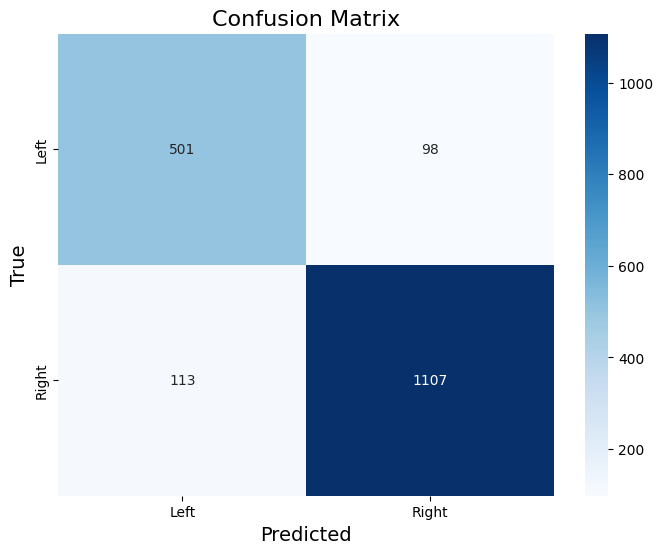

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       599
         1.0       0.92      0.91      0.91      1220

    accuracy                           0.88      1819
   macro avg       0.87      0.87      0.87      1819
weighted avg       0.88      0.88      0.88      1819



In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Merge extracted features with metadata (on PatientID + SampleID + Structure)
df_train_merged = pd.merge(df_train_features, df_train, on=["PatientID", "SampleID", "Structure"], how="left")
df_test_merged = pd.merge(df_test_features, df_test, on=["PatientID", "SampleID", "Structure"], how="left")

# Define clinical categorical variables for one-hot encoding
categorical_cols = ['Sex', 'PVC_transition', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea']

# One-hot encode categorical variables
df_train_merged = pd.get_dummies(df_train_merged, columns=categorical_cols, drop_first=True)
df_test_merged = pd.get_dummies(df_test_merged, columns=categorical_cols, drop_first=True)

# Align test columns with train columns, fill missing with 0
df_test_merged = df_test_merged.reindex(columns=df_train_merged.columns, fill_value=0)

# Columns to drop (identifiers, labels, and columns related to label derivation)
drop_cols = [
    "PatientID", "SampleID", "Structure",
    "label", "normalized_label",
    "SOO", "SOO_chamber", "SOO_Chamber_Mapped",
    "region_label"
]

# Filter only selected features + clinical categorical dummies in train
clinical_dummies = [col for col in df_train_merged.columns if any(col.startswith(c) for c in categorical_cols)]
X_train = df_train_merged[selected_features.tolist() + clinical_dummies].copy()

# Drop columns in drop_cols if they exist in X_train
cols_to_drop = [col for col in drop_cols if col in X_train.columns]
X_train = X_train.drop(columns=cols_to_drop)

y_train = df_train_merged["label"]

# Same filtering for test set, reindex columns to match train
X_test = df_test_merged[selected_features.tolist() + clinical_dummies].copy()
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_test = df_test_merged["label"]

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

KGBoost

In [19]:
df_train_features.to_csv("data/df_train_features.csv", index=False)
df_test_features.to_csv("data/df_test_features.csv", index=False)


In [20]:
df_train_features.to_pickle("data/df_train_features.pkl")
df_test_features.to_pickle("data/df_test_features.pkl")


In [21]:
df_train_merged = pd.merge(df_train_features, df_train, on=["PatientID", "SampleID", "Structure"], how="left")
df_test_merged = pd.merge(df_test_features, df_test, on=["PatientID", "SampleID", "Structure"], how="left")


In [22]:
# Define las columnas categóricas de los metadatos clínicos para codificar
categorical_cols = ['Sex', 'PVC_transition', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea']

# Codifica columnas categóricas en train y test (one-hot encoding)
df_train_merged = pd.get_dummies(df_train_merged, columns=categorical_cols, drop_first=True)
df_test_merged = pd.get_dummies(df_test_merged, columns=categorical_cols, drop_first=True)

# Asegura que test tenga las mismas columnas que train (añade columnas faltantes con 0)
df_test_merged = df_test_merged.reindex(columns=df_train_merged.columns, fill_value=0)


In [25]:
# Columnas que no usamos como features
drop_cols = ["PatientID", "SampleID", "Structure", "label", "normalized_label", "SOO", "SOO_chamber", "SOO_Chamber_Mapped", "region_label"]

# Filtrar las columnas para X
X_train_final = df_train_merged.drop(columns=drop_cols, errors='ignore')
y_train_final = df_train_merged["label"]

X_test_final = df_test_merged.drop(columns=drop_cols, errors='ignore')
y_test_final = df_test_merged["label"]



Columnas no numéricas a eliminar: ['Leads']


c:\Users\expos\anaconda3\envs\CompBioMed25\lib\site-packages\xgboost\core.py:158: UserWarning: [20:43:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7641561297416163
Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.84      0.70       599
         1.0       0.90      0.73      0.81      1220

    accuracy                           0.76      1819
   macro avg       0.75      0.78      0.75      1819
weighted avg       0.80      0.76      0.77      1819



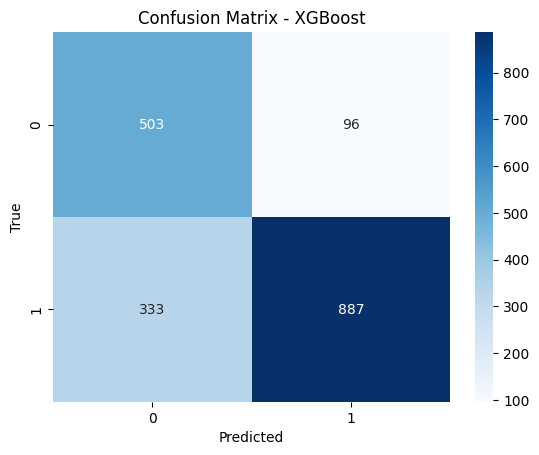

In [27]:
import xgboost as xgb

# Detectar columnas no numéricas en X
non_numeric_cols = X_train_final.select_dtypes(include=['object']).columns
print("Columnas no numéricas a eliminar:", list(non_numeric_cols))

# Eliminar columnas no numéricas
X_train_final = X_train_final.drop(columns=non_numeric_cols, errors='ignore')
X_test_final = X_test_final.drop(columns=non_numeric_cols, errors='ignore')

# Crear y entrenar modelo
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
model.fit(X_train_final, y_train_final)

# Predecir y evaluar
y_pred = model.predict(X_test_final)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(y_test_final, y_pred))
print("Classification Report:\n", classification_report(y_test_final, y_pred))

cm = confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision Left:", precision_score(y_test_final, y_pred, pos_label=0))
print("Recall Left:", recall_score(y_test_final, y_pred, pos_label=0))
print("F1-score Left:", f1_score(y_test_final, y_pred, pos_label=0))

print("Precision Right:", precision_score(y_test_final, y_pred, pos_label=1))
print("Recall Right:", recall_score(y_test_final, y_pred, pos_label=1))
print("F1-score Right:", f1_score(y_test_final, y_pred, pos_label=1))


Precision Left: 0.6016746411483254
Recall Left: 0.8397328881469115
F1-score Left: 0.7010452961672473
Precision Right: 0.9023397761953205
Recall Right: 0.7270491803278688
F1-score Right: 0.805265546981389


SHAP TO TEST ACCURACY

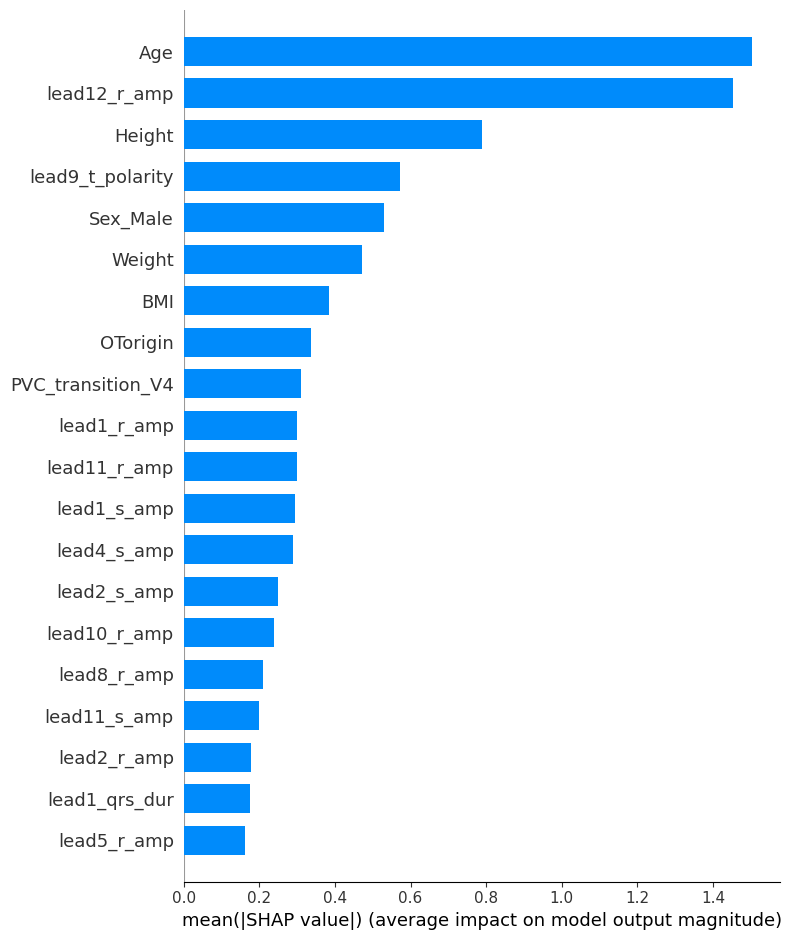

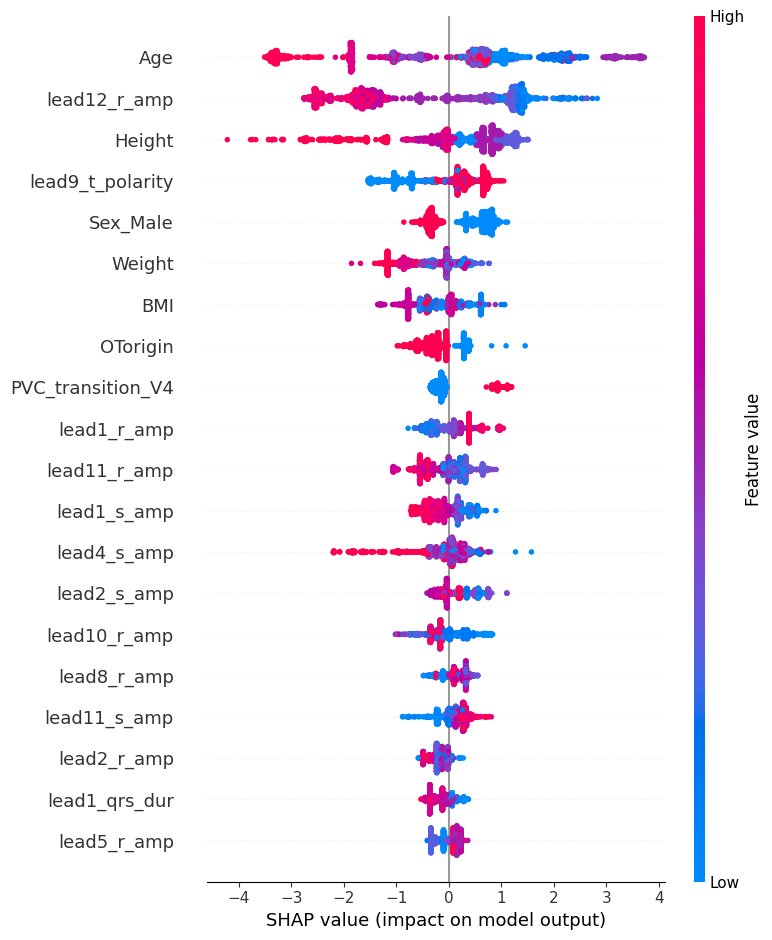

In [30]:
import shap

# Crea explainer para el modelo XGBoost
explainer = shap.TreeExplainer(model)

# Calcula valores SHAP para el set de test
shap_values = explainer.shap_values(X_test_final)

# Plot resumen de importancia global (bar chart)
shap.summary_plot(shap_values, X_test_final, plot_type="bar")

# Plot resumen con impacto de cada feature en cada predicción
shap.summary_plot(shap_values, X_test_final)

# Para un solo ejemplo (índice 0)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_final.iloc[0,:])


In [31]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_final, y_train_final, cv=5, scoring='accuracy')
print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", scores.mean())


[20:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[20:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[20:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[20:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[20:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "u

Cross-validated accuracy scores: [0.53539616 0.66291608 0.68667917 0.71998124 0.86819887]
Mean accuracy: 0.6946343046682657
